# TP4
### Physique Numérique (PHY-3500)
### Par: Simon Gauthier, Laurent Émond, Thomas Charland
### Présenté à: Xavier Roy-Pomerleau et Antoine Allard
### Remis le: 14 avril 2025

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### TP4.1 Intégration numérique de la dynamique épidémiologique SIS (50 points)

#### a)

On peut simplement solutionner analytiquement l'équation quadratique suivante:
$$
0=(R_0-1)i-R_0i^2
$$
On trouve donc que les solutions, ou états stationnaires, sont:
$$
i^*_1=0\qquad\qquad i^*_2=1-\frac{1}{R_0}
$$
Puisque $i^*_{1,2}$ doit être dans l'intervalle [0,1], cela impose les valeurs $R_0\ge1$.

#### b)

En utilisant $\frac{di}{d\tau}=i'$, on peut placer dans la forme de Bernouilli, soit $i'+p(\tau)i=q(\tau)i^n$:
$$
    i'+(1-R_0)i=(-R_0)i^2
$$
où $p(\tau)=1-R_0$, $q(\tau)=(-R_0)$ et $n=2$.

On peut alors diviser par $i^{-n}=i^{-2}$:
$$
    i^{-2}i'+(1-R_0)i^{-1}=-R_0
$$
On utilise ensuite la substitution $v=i^{1-n}=i^{-1}$. 
$$
    v^2i'+(1-R_0)v=-R_0
$$
On doit également trouver $i'$ en fonction de $v$. On peut dériver implicitement notre substitution et isoler $i'$, soit $i'=-i^2v'=-\frac{1}{v^2}v'$. On remplace:
$$
-v'+(1-R_0)v=-R_0
$$
On divise par $-1$:
$$
v'+(R_0-1)v=R_0
$$
Cette EDO en $v$ est linéaire, on peut donc la résoudre à l'aide de la méthode du facteur d'intégration $\mu(\tau)$. On multiplie donc l'équation par $\mu(\tau)$:
$$
v'\mu(\tau)+(R_0-1)v\mu(\tau)=R_0\mu(\tau)
$$
On assume pour l'instant la condition $\mu(\tau)(R_0-1)=\mu'(\tau)$. On a donc:
$$
v'\mu(\tau)+v\mu'(\tau)=R_0\mu(\tau)
$$
On remarque que le côté gauche est simplement la dérivée du produit $v\mu(\tau)$. On a donc:
$$
(v\mu(\tau))'=R_0\mu(\tau)
$$
On intègre alors des deux côtés par rapport à $\tau$ et on obtient:
$$
v\mu(\tau)+C=\int R_0\mu(\tau) d\tau
$$
où $C$ est notre constante d'intégration. On isole $v$:
$$
v=\frac{\int R_0\mu(\tau) d\tau - C}{\mu(\tau)}
$$
Maintenant, sachant que $\frac{\mu'(\tau)}{\mu(\tau)}=R_0-1$, on trouve que $\mu(\tau)=e^{\int (R_0-1) d\tau + k}=Ke^{(R_0-1)\tau}$ où $K=e^k$ est une constante d'intégration. On a donc:
$$
v=\frac{K\int R_0e^{(R_0-1)\tau} d\tau - \frac{C}{k}}{Ke^{(R_0-1)\tau}}
$$
On définit $c_1=\frac{c}{K}$ pour avoir:
$$
\begin{align*}
v&=\frac{\int R_0e^{(R_0-1)\tau} d\tau - c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+c_2-c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}{e^{(R_0-1)\tau}}
\end{align*}
$$
où $C=c_2-c_1$ est une constante. On peut alors exprimer $v$ en fonction de $i$ et isoler $i$:
$$
i=\frac{1}{v}=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}
$$
On peut ensuite utiliser une condition initiale $i(0)=i_0$ pour obtenir:
$$
i_0=\frac{e^{(R_0-1)0}}{\frac{R_0}{R_0-1}e^{(R_0-1)0}+C}=\frac{1}{\frac{R_0}{R_0-1}+C}
$$
On a donc:
$$
C= \frac{R_0-1-R_0i_0}{i_0(R_0-1)}
$$
On a donc:
$$
i(\tau)=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+\frac{R_0-1-R_0i_0}{i_0(R_0-1)}}=\frac{i_0(R_0-1)e^{(R_0-1)\tau}}{i_0R_0e^{(R_0-1)\tau}+R_0-1-i_0R_0}
$$
pour $\tau>0$. Cela impose la branche positive de la solution particulière, soit $i>0$.

On peut tracer cette solution pour une condition initiale $i_0=0.5$ et une valeur $R_0=1.5$:

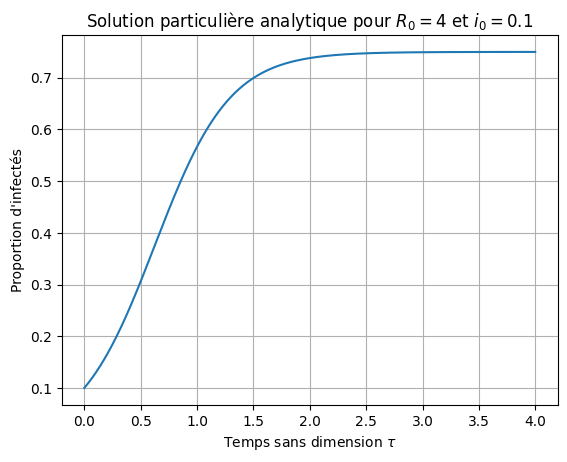

In [2]:
def analytical(times, R0, i0):
    """ Solution particulière analytique du modèle SIR."""
    return (i0*(R0-1)*np.exp((R0-1)*times))/(i0*R0*np.exp((R0-1)*times)+R0-1-i0*R0)


R0 = 4 # nombre de personnes infectées par une personne infectée
i0 = 0.1 # proportion d'infectés au temps t=0

times = np.linspace(0, 4, 1000)

plt.plot(times, analytical(times, R0, i0))
plt.title(fr"Solution particulière analytique pour $R_0={R0}$ et $i_0={i0}$")
plt.xlabel(r"Temps sans dimension $\tau$")
plt.ylabel(r"Proportion d'infectés")
plt.grid()
plt.show()

#### c)
On implémente ici les trois intégrateurs numériques demandés. Ces derniers prennent en entrée une variable $T$, qui détermine le nombre de pas de taille $h$ qui seront faits. Par exemple, pour $T=3$, les deux vecteurs retournées (temps et proportion d'infectés) auront une longueur $T+1$ (puisque les indices débutent à 0). Pour le vecteur de temps, les valeurs choisies seront des multiples de $h$, soit $0, h, 2h, ...$.

In [3]:
def infection_rate(i, R0):
    """Dérivée de la fonction d'infection par rapport au temps dans dimension tau"""
    return (R0-1)*i-R0*i**2

def euler(T, h, R0, i0):
    """ Méthode d'Euler pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        i[j] = i[j-1] + h*infection_rate(i[j-1], R0)
    return h*np.arange(0, T+1), i

def rk2(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 2 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        i[j] = i[j-1] + k2
    return h*np.arange(0, T+1), i

def rk4(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 4 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        k3 = h*infection_rate(i[j-1] + 0.5*k2, R0)
        k4 = h*infection_rate(i[j-1] + k3, R0)
        i[j] = i[j-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    return h*np.arange(0, T+1), i

#### d)
On implémente ici la méthode du ratio dorée pour arriver à isoler une valeur de $h$ pour laquelle la fonction d'erreur donne une valeur entre 0.99$\delta$ et 1.01$\delta$. Puisque la méthode du ratio doré permet de trouver un minimum d'une fonction, et que l'on veut plutôt une valeur d'erreur dans un certain intervalle, il faut ajouter une étape. En effet, lorsque l'on trouve une valeur de $h$ pour laquelle l'erreur est inférieure à 0.99$\delta$, signifiant que nous avons trouvé une solution "trop" précise, une interpolation est faite pour approximer le $h$ qui aurait donné une erreur égale à $\delta$. Puisque l'on sait qu'une relation à peu près linéaire relie les logarithmes de l'erreur et du pas de temps, il est possible d'interpolation linéairement en log-log et de retourner la valeur de $h$ interpolée.

In [4]:
def error(f, T, h, R0, i0):
    times, i = f(T, h, R0, i0)
    i_analytical = analytical(times, R0, i0)
    error = np.sqrt(1/(len(i)+1)*np.sum((i-i_analytical)**2))
    return error

def golden_ratio_method(f, h1, h4, T, R0, i0, delta, max_iter=100):
    z = (1 + np.sqrt(5)) / 2 # nombre d'or
    h2 = h4 - (h4-h1)/z
    h3 = h1 + (h4-h1)/z

    last_h2_log = np.log10(h1)
    last_e2_log = np.log10(error(f, T, h1, R0, i0))

    for i in range(max_iter):
        e2 = error(f, T, h2, R0, i0)
        e3 = error(f, T, h3, R0, i0)
        if i > 0:
            if abs(e2) < 0.99*delta:
                # sachant que log(e) est propotionnel à log(h)
                # on interpole linéaire pour trouver le h pour lequel
                # l'erreur est delta
                h2_log = np.log10(h2)
                e2_log = np.log10(e2)
                log_delta = np.log10(delta)
                
                interp_h2_log = h2_log - (e2_log - log_delta) * (h2_log - last_h2_log) / (e2_log - last_e2_log)
                interp_h2 = 10**interp_h2_log
                return interp_h2
        
        last_h2_log = np.log10(h2)
        last_e2_log = np.log10(e2)
        
        if e2 < e3:
            h4, h3 = h3, h2
            h2 = h4 - (h4-h1)/z

        else:
            h2, h1 = h3, h2
            h3 = h1 + (h4-h1)/z

    raise ValueError("La méthode de la section dorée n'a pas convergé dans le nombre d'itérations maximal autorisé.")

R0/i0,Euler,RK2,RK4
1.5/0.1,1.31e-02 [1.00e-06],2.22e-01 [3.86e-07],7.28e-01 [7.25e-07]
1.5/0.9,8.45e-04 [1.00e-06],9.73e-03 [1.00e-06],1.18e-01 [7.32e-07]
2/0.1,4.98e-03 [1.00e-06],5.51e-02 [9.93e-07],3.09e-01 [8.73e-07]
2/0.9,8.01e-04 [1.00e-06],8.92e-03 [1.00e-06],1.01e-01 [8.03e-07]
3/0.1,2.24e-03 [1.00e-06],2.31e-02 [1.00e-06],1.42e-01 [9.61e-07]
3/0.9,7.49e-04 [1.00e-06],7.88e-03 [1.00e-06],7.78e-02 [8.88e-07]


R0/i0,Euler,RK2,RK4
1.5/0.1,4.13e-03 [1.00e-07],9.95e-02 [8.30e-08],4.59e-01 [8.30e-08]
1.5/0.9,2.67e-04 [1.00e-07],4.47e-03 [1.00e-07],7.25e-02 [8.96e-08]
2/0.1,1.58e-03 [1.00e-07],2.54e-02 [1.00e-07],1.95e-01 [9.45e-08]
2/0.9,2.53e-04 [1.00e-07],4.10e-03 [1.00e-07],6.17e-02 [9.37e-08]
3/0.1,7.08e-04 [1.00e-07],1.07e-02 [1.00e-07],8.97e-02 [9.92e-08]
3/0.9,2.36e-04 [1.00e-07],3.61e-03 [1.00e-07],4.77e-02 [9.80e-08]


R0/i0,Euler,RK2,RK4
1.5/0.1,1.31e-03 [1.00e-08],4.46e-02 [9.91e-09],2.89e-01 [9.05e-09]
1.5/0.9,8.43e-05 [1.00e-08],2.06e-03 [1.00e-08],4.45e-02 [9.87e-09]
2/0.1,4.99e-04 [1.00e-08],1.17e-02 [1.00e-08],1.23e-01 [9.79e-09]
2/0.9,7.99e-05 [1.00e-08],1.89e-03 [1.00e-08],3.79e-02 [1.00e-08]
3/0.1,2.24e-04 [1.00e-08],4.98e-03 [1.00e-08],5.66e-02 [9.99e-09]
3/0.9,7.47e-05 [1.00e-08],1.67e-03 [1.00e-08],2.93e-02 [1.01e-08]


R0/i0,Euler,RK2,RK4
1.5/0.1,4.13e-04 [1.00e-09],2.01e-02 [1.00e-09],1.82e-01 [9.52e-10]
1.5/0.9,2.67e-05 [1.00e-09],9.55e-04 [1.00e-09],2.73e-02 [1.01e-09]
2/0.1,1.58e-04 [1.00e-09],5.44e-03 [1.00e-09],7.73e-02 [9.93e-10]
2/0.9,2.53e-05 [1.00e-09],8.75e-04 [1.00e-09],2.33e-02 [1.00e-09]
3/0.1,7.09e-05 [1.00e-09],2.31e-03 [1.00e-09],3.58e-02 [1.00e-09]
3/0.9,2.36e-05 [1.00e-09],7.71e-04 [1.00e-09],1.81e-02 [1.00e-09]


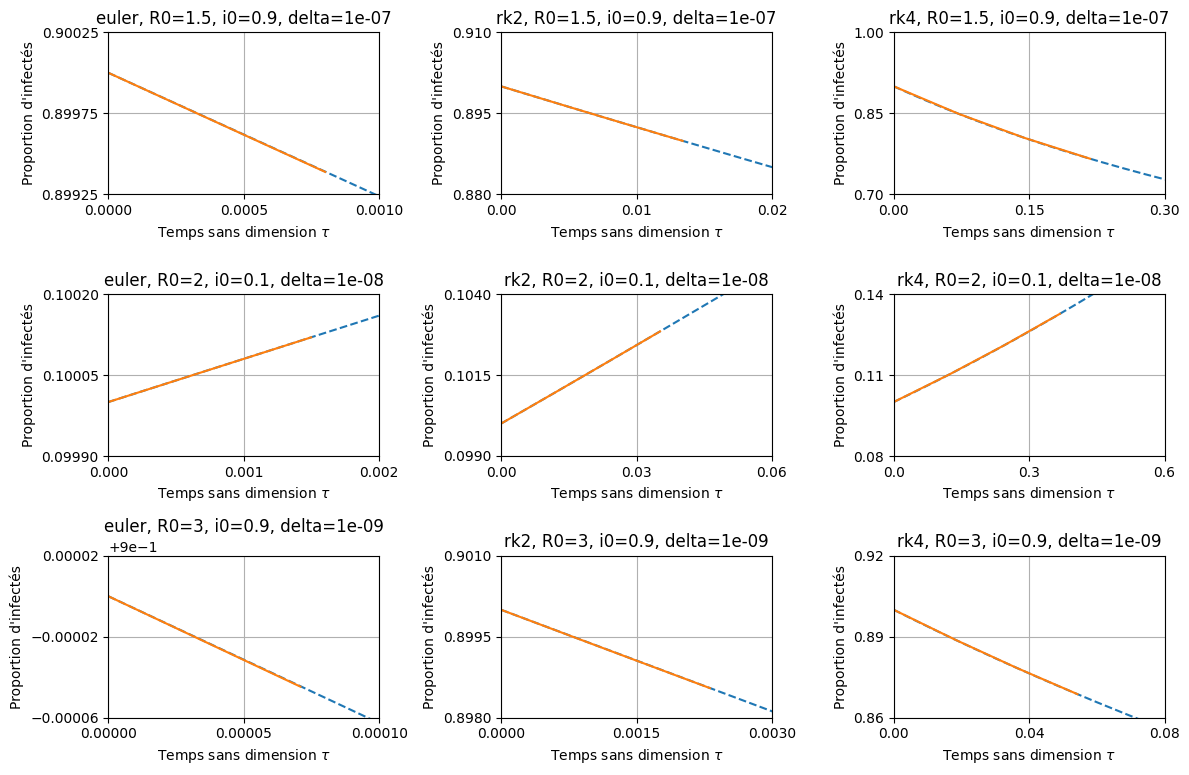

In [5]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.ticker as ticker


R0i0_pairs = [(1.5, 0.1), (1.5, 0.9), (2, 0.1), (2, 0.9), (3, 0.1), (3, 0.9)]
deltas = [1e-6, 1e-7, 1e-8, 1e-9]

delta_R0i0_to_show = [
    (1.5, 0.9, 1e-7),
    (2, 0.1, 1e-8), 
    (3, 0.9, 1e-9),
]

T = 3

plt.figure(figsize=(12, 8))

for delta in deltas:
    results = pd.DataFrame(columns=["R0/i0", "Euler", "RK2", "RK4"])

    for R0, i0 in R0i0_pairs:
        times = np.linspace(0, T, 1000) # finer grid for analytical solution

        delta_R0i0 = (R0, i0, delta)

        methods_results = []

        for j, method in enumerate([euler, rk2, rk4]):
            h1 = 1e-10
            h4 = 0.1

            h = golden_ratio_method(method, h1, h4, T, R0, i0, delta)
            t, i = method(T, h, R0, i0)

            if delta_R0i0 in delta_R0i0_to_show:
                plt.subplot(3, 3, 3*delta_R0i0_to_show.index(delta_R0i0)+j+1)
                plt.xlabel(r"Temps sans dimension $\tau$")
                plt.ylabel(r"Proportion d'infectés")
                plt.grid()
                plt.plot(times, analytical(times, R0, i0), label="Analytique", linestyle='--')
                plt.title(f"{method.__name__}, R0={R0}, i0={i0}, delta={delta}")
                plt.plot(t, i)
                dy = max(i) - min(i)
                y_min = min(i) - 0.2 * dy
                y_max = max(i) + 0.2 * dy
                plt.ylim(y_min, y_max)

                dx = max(t) - min(t)
                x_min = 0
                x_max = max(t) + 0.2 * dx
                plt.xlim(x_min, x_max)

                # Fonction pour créer 3 ticks arrondis
                def round_locator(min_val, max_val):
                    range_val = max_val - min_val
                    step = 10**np.floor(np.log10(range_val))
                    for factor in [1, 2, 2.5, 5]:
                        if range_val / (step * factor) <= 4:
                            step *= factor
                            break
                    tick_min = step * np.floor(min_val / step)
                    tick_max = step * np.ceil(max_val / step)
                    ticks = np.linspace(tick_min, tick_max, 3)
                    return np.round(ticks, 8)

                # Appliquer les ticks personnalisés
                xticks = round_locator(x_min, x_max)
                yticks = round_locator(y_min, y_max)
                plt.xticks(xticks)
                plt.yticks(yticks)

                # Forcer notation décimale normale
                ax = plt.gca()
                ax.ticklabel_format(style='plain', axis='both')  # <- no scientific notation

            error_at_h = error(method, T, h, R0, i0)

            methods_results.append(f"{h:.2e} [{error_at_h:.2e}]")

        results.loc[len(results)] = [f"{R0}/{i0}"] + methods_results


    display(HTML(f"<h2>Valeur de h[erreur] pour delta = {delta}</h2>"))
    # display datafram without index and with borders
    display(HTML(results.to_html(index=False, border=1, justify='center')))

plt.suptitle("")
plt.tight_layout()
plt.show()



On remarque dans les tableaux ci-haut que le comportement est respecté pour la majorité des cas. En effet, on voit que l'erreur (entre crochet) converge dans l'intervalle [0.99, 1.01]$\delta$. On remarque aussi que la grandeur des pas nécessaire pour atteindre cette précision est plus petite pour Euler que pour RK2 et encore plus que pour RK4. On remarque aussi, tel qu'attendu, qu'il faut un pas plus fin pour atteindre une erreur plus petite.

Dans les graphiques, on remarque que les pas choisis permettent de bien suivre la courbe analytique.

#### e)
On simplement créer un espace logarithmique de valeurs de h et calculer l'erreur pour chacun de ces pas de temps. On prend une échelle logarithmique afin de couvrir un plus écart de pas de temps sans devoir choisir énormément de valeurs. 
On peut ensuite tracer en échelle logarithmiques ces valeurs de $h$ et d'erreur associée et prendre la pente d'une régression linéaire de ces points.
Cette pente nous donne la valeur de l'ordre d'erreur $d$ soit 2.00 pour Euler, 3.00 pour RK2 et 5.01 pour RK4.

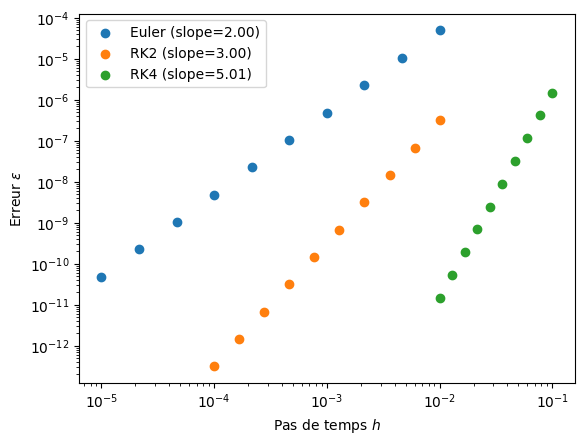

In [6]:
log_h_space_euler = np.logspace(-5, -2, 10)
log_h_space_rk2 = np.logspace(-4, -2, 10)
log_h_space_rk4 = np.logspace(-2, -1, 10)

R0 = 4
i0 = 0.1

errors_euler = np.array([error(euler, T, h, R0, i0) for h in log_h_space_euler]) # erreur pour chacune des valeurs de T
errors_rk2 = np.array([error(rk2, T, h, R0, i0) for h in log_h_space_rk2]) # erreur pour chacune des valeurs de T
errors_rk4 = np.array([error(rk4, T, h, R0, i0) for h in log_h_space_rk4]) # erreur pour chacune des valeurs de T

T = 3

def slope(x, y):
    """ Calcul de la pente d'une régression linéaire """
    return np.polyfit(x, y, 1)[0]

slope_euler = slope(np.log(log_h_space_euler), np.log(errors_euler))
slope_rk2 = slope(np.log(log_h_space_rk2), np.log(errors_rk2))
slope_rk4 = slope(np.log(log_h_space_rk4), np.log(errors_rk4))

plt.scatter(log_h_space_euler, errors_euler, label=f"Euler (slope={slope_euler:.2f})")

plt.scatter(log_h_space_rk2, errors_rk2, label=f"RK2 (slope={slope_rk2:.2f})")
plt.scatter(log_h_space_rk4, errors_rk4, label=f"RK4 (slope={slope_rk4:.2f})")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Pas de temps $h$")
plt.ylabel(r"Erreur $\epsilon$")
plt.legend()
plt.show()

### TP4.2 Simulation Monte-Carlo de la dynamique SIS (50 points)

#### a)


Ici nous sommes en présence d'une situation probabiliste décrit par la Binomiale de paramètre N et P où N représente le nombre totale de liasons possible ($\frac{n(n - 1)} {2}$) et P représente la probabilité que le liens se concrétise (p). Le résonnement derrière cette expréssion vient du fait qu'il y a un nomrbe de liaisons possible équvalent à ($\frac{n(n - 1)} {2}$). Pour arriver à cette équation, nous savons que chaque noeud est lié à (n-1) autres noeuds. Cependant, il ne faut pas compter les liens en double. Ensuite, chaque liaisons correspond à une épreuve de Bernouilli de probabilité p. C'est pourquoi que la probabilité d'avoir m liens (succès) est décrit par la loi Binomiale suivante :

$$
    P(M = m) = \binom{N}{m} P^m (1-P)^{N-m}
$$

#### b)


Afin d'obtenir le nombre de lien moyen de notre expréssion, il suffit de calculer l'espérance. L'espérance de la loi Binomiale équivaut à ($N\cdot P$)[1]. Celle-ci peut être démontré en écriavant la relation binomiale en une sommation de loi de Bernouilli $Y_k$ possédant tous une probabilité identique de P.
$$
    M = \sum_{k=1}^{N}Y_{k}
$$
Il est ainsi possible d'appliquer l'espérance à notre nouvelle équation.
$$
\begin{align}
    \mathbb{E}[M] &= \mathbb{E}\left[\sum_{k=1}^{N}Y_{k}\right]\\
    &= \sum_{k=1}^{N}\mathbb{E}[Y_{k}]\\
    &= \sum_{k=1}^{N} P \\
    &= NP
\end{align}
$$ 

On peut utiliser la même logique pour la variance. De cette manière, nous obtenons que la varaince est égale à $NP(1-P)$
$$
\begin{align}
    \mathbb{V}[M] &= \mathbb{V}\left[\sum_{k=1}^{N}Y_{k}\right]\\
    &= \sum_{k=1}^{N}\mathbb{V}[Y_{k}]\\
    &= \sum_{k=1}^{N} P(1-P) \\
    &= NP(1-P)
\end{align}
$$ 
Finalement, sachant que l'écart-type correspond à la racine de la variance, nous avons que 
$$
    \sigma = \sqrt{NP(1-P)}
$$

#### c)


Avant d'implémenter un algorithme qui génère des graphes en utilisant le modèle d’Erdős–Rényi, nous implémentons certaines fonctions permettant de déterminer théoriquement, grâce à la loi Binomiale, l'espérance, la variance ainsi que l'écart-type. Ces fonctions consiste simplement en l'implémentation des équations identifiés au numéro précédent.

In [ ]:
def get_esperance(n, P):
    """Calcul de l'espérance d'un relation Erdos-Renyi"""
    return n*(n-1)/2 * P

def get_variance(n, P):
    """Calcul de la variance d'un relation Erdos-Renyi"""
    return n*(n-1)*P*(1-P)/2

def get_std(n, P):
    """Calcul de l'écart-type d'un relation Erdos-Renyi"""
    return np.sqrt(get_variance(n, P))

Ensuite, nous implémentons une classe permettant de construire des graphes en utilisant le modèle d’Erdős–Rényi. Pour ce faire, nous construisons une matrice (N X N) représentant l'ensemble des liens possible entre les noeuds. Le lien à l'adresse (i,j) représente le lien entre le noeuds i et j. Bien entendu, la diagonale est égalé à 0 puisqu'un noeud ne peut pas être lié à lui même. Puisque les liens ne sont pas directionnel ([i,j] = [j,i]) il est possible de garder seulement la partie supérieur de la matrice et de la rendre symétrique.

In [41]:
class Array_Erdos_Renyi:
    def __init__(self, n, p):
        self.n = n
        self.p = p
        self.array = np.random.rand(n, n) < p # Création d'une matrice aléatoire
        self.array = np.triu(self.array, 1) # On ne garde que la partie supérieure de la matrice
        self.array = self.array + self.array.T # On symétrise la matrice
        self.array = self.array.astype(int) # On convertit en entier (False=0, True=1)
        np.fill_diagonal(self.array, 0) # On met des 0 sur la diagonale (False=0)

    def Get_Nb_Links(self):
        """Calcul de le nombre de liens seulement dans la partie supérieure de la matrice"""
        return np.sum(self.array[np.triu_indices(self.n, 1)])
    
    def __str__(self):
        return str(self.array)

Espérance Théorique : 990.00
Variance Théorique : 792.00
Ecart-type Théorique : 28.14
Espérance Pratique : 990.08
Variance Pratique : 804.97
Ecart-type Pratique : 28.37


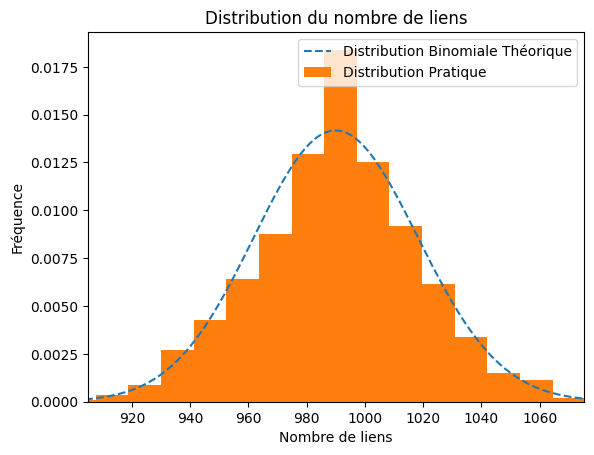

In [64]:
np.random.seed(0) # Pour la reproductibilité

N_nodes = 100
p = 0.2
print(f"Espérance Théorique : {get_esperance(N_nodes, p):.2f}")
print(f"Variance Théorique : {get_variance(N_nodes, p):.2f}")
print(f"Ecart-type Théorique : {get_std(N_nodes, p):.2f}")

mean_links = []
N_iterations = 1000
for i in range(N_iterations):
    a = Array_Erdos_Renyi(100, 0.2)
    mean_links.append(a.Get_Nb_Links())
    
print(f"Espérance Pratique : {np.mean(mean_links):.2f}")
print(f"Variance Pratique : {np.var(mean_links):.2f}")
print(f"Ecart-type Pratique : {np.std(mean_links):.2f}")

# Fit de la distribution Binomial
from scipy.stats import binom
x = np.arange(0, N_nodes*(N_nodes-1)/2 + 1)
binom_dist = binom.pmf(x, N_nodes*(N_nodes-1)/2 + 1, p)
plt.plot(x, binom_dist, label="Distribution Binomiale Théorique", linestyle='--')
plt.hist(mean_links, bins=20, density=True ,label="Distribution Pratique")
plt.title("Distribution du nombre de liens")
plt.xlabel("Nombre de liens")
plt.xlim(np.mean(mean_links)-3*np.std(mean_links), np.mean(mean_links)+3*np.std(mean_links))
plt.ylabel("Fréquence")
plt.legend()
plt.show()

Nous pouvons observer que l'espérance théorique ainsi que l'écart-type théorique sont très similaire à leurs homologues expérimentaux. Lorsque l'on compare la distribution pratique mesuré avec la distribution théorque, nous remarquons que celles-ci sont très similaire et en accordance.

#### d)

Afin de faciliter l'intégration de la simulation Monte-Carlo aux modules NetworkX, nous implémentons une class directement dérivé de l'objet Graph de NetworkX. À cette classe nous ajoutons des arrays utilisés pour effectuer les différentes étapes de la simulation.

In [ ]:
class SIS(nx.Graph):
    def __init__(self, network_path, alpha, beta):
        """Initialisation du modèle SIS"""
        # On charge le réseau
        G_temp = nx.read_adjlist(network_path)

        # On initialise la classe mère
        super().__init__()
        self.add_nodes_from(G_temp.nodes(data=True))
        self.add_edges_from(G_temp.edges(data=True))

        # Initialisation de nos paramètres
        self.sis_alpha = alpha  # taux de guérison
        self.sis_beta = beta    # taux d'infection
        self.sis_N = self.number_of_nodes()  # nombre de noeuds
        self.sis_nodes = np.zeros(self.sis_N, dtype=bool)  # tableau des noeuds
        self.sis_temp_nodes = np.zeros(self.sis_N, dtype=bool)  # tableau temporaire des noeuds
        self.sis_edges = np.zeros((self.sis_N, self.sis_N), dtype=bool)  # tableau des liens

        self.sis_nodes_colors = np.zeros(self.sis_N, dtype=str)  # tableau des couleurs
        self.sis_nodes_colors[:] = "c"  # couleur par défaut

        self._set_links_array()  # Initialisation du tableau des liens
    
    def _init_infected(self, p):
        """Initialisation des noeuds infectés"""
        self.sis_nodes = np.zeros(self.sis_N, dtype=bool)  # tableau des noeuds
        self.sis_nodes[np.random.rand(self.sis_N) < p] = True

    def _set_links_array(self):
        """Initialisation du tableau des liens"""
        for link in self.edges():
            i, j = int(link[0]), int(link[1])
            self.sis_edges[i, j] = True
            self.sis_edges[j, i] = True
    
    def _reset_temp_nodes(self):
        """Réinitialisation du tableau temporaire des noeuds"""
        self.sis_temp_nodes = np.zeros(self.sis_N, dtype=bool)  # tableau temporaire des noeuds
    
    def _compute_healed_nodes(self):
        """Guérison des noeuds"""
        # On parcourt tous les noeuds
        for i in range(self.sis_N):
            if self.sis_nodes[i]:
                # Si le noeud est infecté, on le guérit avec une probabilité alpha
                if np.random.rand() < self.sis_alpha:
                    self.sis_nodes[i] = False
        
    def _infected_linked_to_node(self, index) -> bool:
        """Infection des noeuds liés à un noeud infecté"""
        ret = False
        if self.sis_nodes[index]:
            ret = True
        else:
            if np.random.rand() < self.sis_beta:
                ret = True
            else:
                 pass
        return ret

    def _compute_infected_nodes(self):
        """Infection des noeuds"""
        for i in range(self.sis_N):
            # On parcourt tous les noeuds
            if self.sis_nodes[i]:
                # Si le noeud est infecté, on parcourt tous ses voisins
                for j in range(self.sis_N):
                    if self.sis_edges[i, j]:
                        # Si le noeud j est infecté, on l'infecte avec une probabilité beta
                        if self._infected_linked_to_node(j):
                            # Le noeud j est infecté
                            self.sis_temp_nodes[j] = True            
            else:
                continue
        # On met à jour le tableau des noeuds
        self.sis_nodes = np.logical_or(self.sis_nodes, self.sis_temp_nodes)
        # On réinitialise le tableau temporaire
        self._reset_temp_nodes()
    
    def _set_color_infected_nodes(self):
        """Mise à jour des couleurs des noeuds"""
        for i in range(self.sis_N):
            if self.sis_nodes[i]:
                self.sis_nodes_colors[i] = "r"
            else:
                self.sis_nodes_colors[i] = "c"
    
    def init_infected(self, p):
        """Initialisation des noeuds infectés"""
        self.sis_nodes = np.zeros(self.sis_N, dtype=bool)  # tableau des noeuds
        self.sis_nodes[np.random.rand(self.sis_N) < p] = True

        # On met à jour les couleurs des noeuds
        self._set_color_infected_nodes()

    def simulate_one_iteration(self,) -> None:
        """Simulation d'une itération du modèle SIS""" 
        # On guérit les noeuds
        self._compute_healed_nodes()
        # On infecte les noeuds
        self._compute_infected_nodes()
        # On met à jour les couleurs des noeuds
        self._set_color_infected_nodes()
        return None

    def simulate_multiple_iteration(self, T) -> None:
        """Simulation du modèle SIS"""
        for t in range(T):
            # On guérit les noeuds
            self._compute_healed_nodes()
            # On infecte les noeuds
            self._compute_infected_nodes()
        
        # On met à jour les couleurs des noeuds
        self._set_color_infected_nodes()
        return None
            
    def get_nb_infected_nodes(self) -> int:
        """Retourne le nombre de noeuds infectés"""
        return np.sum(self.sis_nodes)

    def get_nb_healthy_nodes(self) -> int:
        """Retourne le nombre de noeuds succeptibles"""
        return self.sis_N - np.sum(self.sis_nodes)
        
    @staticmethod
    def create_network(n, p, network_path):
        """Création d'un réseau aléatoire d'Erdos-Renyi"""
        G = nx.Graph()
        G.add_nodes_from(range(n))
        for i in range(n):
            for j in range(i+1, n):
                if np.random.rand() < p:
                    G.add_edge(i, j)
        # Save the graph to the adjlist file
        nx.write_adjlist(G, network_path)

Situation initiale
Nombre de noeuds infectés : 14
Nombre de noeuds suceptibles : 86


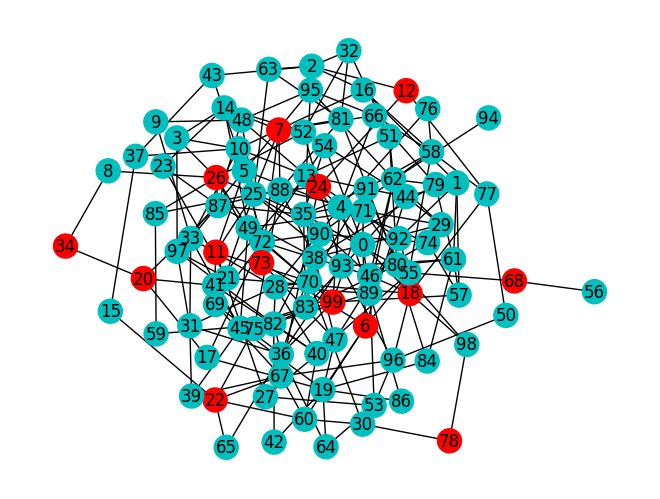

Situation après 100 itérations
Nombre de noeuds infectés : 0
Nombre de noeuds suceptibles : 100


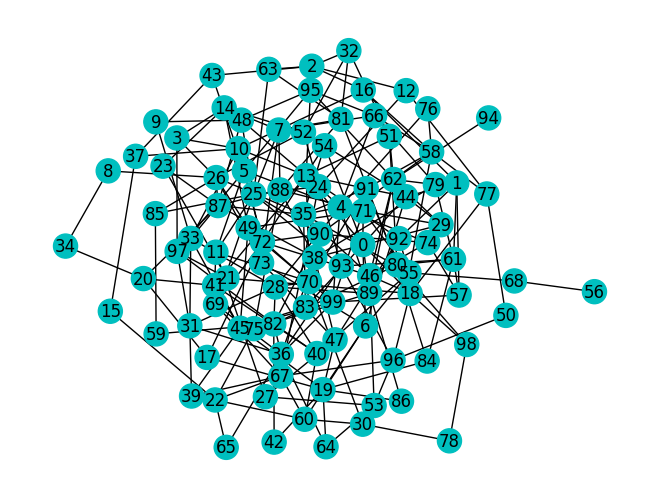

In [ ]:
# Set the random seed for reproducibility
#np.random.seed(0)

#SIS.create_network(10, 0.5, "data/reseau_petit.adj")

# Create a SIS object
# SIS(path_to_network, alpha, beta)
# graph = SIS("data/reseau_petit.adj", 0.25, 1)
graph = SIS("data/reseau.adj", 0.2, 0.1)
pos = nx.kamada_kawai_layout(graph)  # très lisible

graph.init_infected(0.1)
print("Situation initiale")
print("Nombre de noeuds infectés :", graph.get_nb_infected_nodes())
print("Nombre de noeuds suceptibles :", graph.get_nb_healthy_nodes())
nx.draw(graph, pos, with_labels=True, node_color=graph.sis_nodes_colors, node_size=300)
plt.show()

graph.simulate_multiple_iteration(100)
print("Situation après 100 itérations")
print("Nombre de noeuds infectés :", graph.get_nb_infected_nodes())
print("Nombre de noeuds suceptibles :", graph.get_nb_healthy_nodes())
nx.draw(graph, pos, with_labels=True, node_color=graph.sis_nodes_colors, node_size=300)
plt.show()

Nombre de noeuds infectés : 89.30
Nombre de noeuds suceptibles : 10.70
Ecart-type du nombre de noeuds infectés : 3.19
Ecart-type du nombre de noeuds suceptibles : 3.19


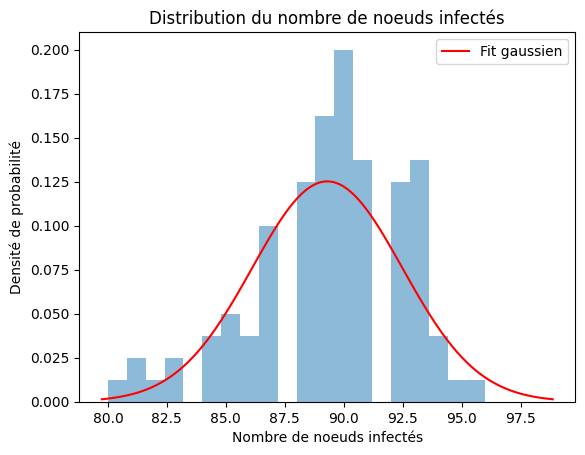

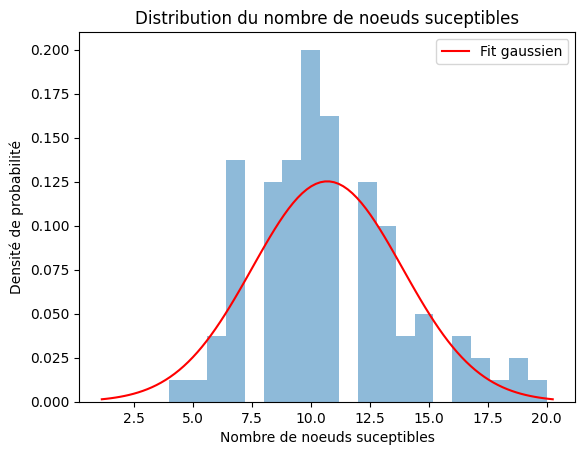

In [ ]:
# Set the random seed for reproducibility
np.random.seed(0)

nb_simulations = 100
nb_infected_nodes = np.zeros(nb_simulations)
nb_healthy_nodes = np.zeros(nb_simulations)

for i in range(nb_simulations):
    graph = SIS("data/reseau.adj", 0.05, 0.1)
    graph.init_infected(0.1)
    graph.simulate_multiple_iteration(100)

    nb_infected_nodes[i] = graph.get_nb_infected_nodes()
    nb_healthy_nodes[i] = graph.get_nb_healthy_nodes()

print(f"Nombre de noeuds infectés : {np.mean(nb_infected_nodes):.2f}")
print(f"Nombre de noeuds suceptibles : {np.mean(nb_healthy_nodes):.2f}")
print(f"Ecart-type du nombre de noeuds infectés : {np.std(nb_infected_nodes):.2f}")
print(f"Ecart-type du nombre de noeuds suceptibles : {np.std(nb_healthy_nodes):.2f}")

# Fit gaussien infectés
mean = np.mean(nb_infected_nodes)
std = np.std(nb_infected_nodes)
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
plt.plot(x, y, color='red', label='Fit gaussien')
plt.hist(nb_infected_nodes, bins=20, density=True, alpha=0.5)
plt.title("Distribution du nombre de noeuds infectés")
plt.xlabel("Nombre de noeuds infectés")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.show()

# Fit gaussien suceptibles
mean = np.mean(nb_healthy_nodes)
std = np.std(nb_healthy_nodes)
x = np.linspace(mean - 3*std, mean + 3*std, 100)
y = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
plt.plot(x, y, color='red', label='Fit gaussien')
plt.hist(nb_healthy_nodes, bins=20, density=True, alpha=0.5)
plt.title("Distribution du nombre de noeuds suceptibles")
plt.xlabel("Nombre de noeuds suceptibles")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.show()

### Références

[1] https://progresser-en-maths.com/loi-binomiale-cours-et-exercices-corriges/#Definition_a_laide_depreuves_de_Bernoulli